In [1]:
include("../src/Conduction.jl");
using Plots, LaTeXStrings;

In [2]:
semiconductor = Conduction.Semiconductor(
1.38 * 10^-23, # Boltzman constant (J.K^-1)
1.6*10^-19, # Electron's charge (C)
10^7, # decay constant of the assumed hydrogen-like localized state wave functions (cm^-1)
0.1 * 1.6*10^-19, # Mode effect of the phonons (J)
2.1 * 10^18, # intrinsic semiconductor's density (cm^-3)
0, # Doping states' density (cm^-3)
0.1 * 1.6 * 10^-19, # Energy to a vacant target site (J)
-2*10^3, # Field (V.cm^-1)
10^13, # Base electron jump rate
-10.0, # Fermi level (J)
2.7, # Intrinsic semiconductor's gaussian width (J)
2.7, # Doping states' gaussian width (J)
2.7 # Amount of disorder
);

T = 300;
range = -15:0.1:15;

In [3]:
Rnn_VRH = (x -> Conduction.RnnVRH(semiconductor, x, T)).(range);
Rnn_Perco = (x -> Conduction.RnnPercoField(semiconductor, x, T)).(range);

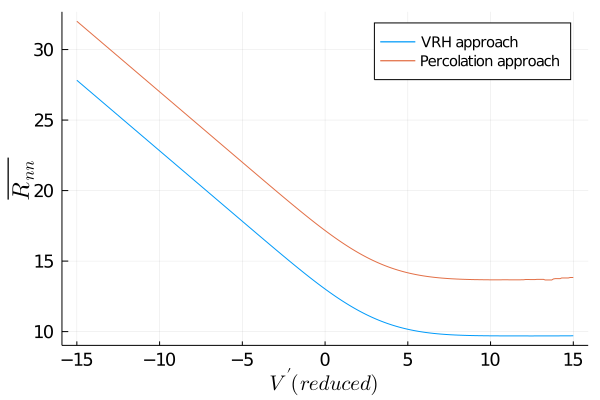

In [19]:
plot(range, Rnn_VRH, xlabel=L"V^\prime(reduced)", ylabel=L"\overline{R_{nn}}", label="VRH approach", xguidefontsize=14,  yguidefontsize=16, legendfontsize=10, ytickfontsize=12,  xtickfontsize=12)
plot!(range, Rnn_Perco, label="Percolation approach")

In [4]:
xf_VRH = ((x, y) -> Conduction.xf(semiconductor, x, y, T)).(Rnn_VRH, range);
xf_Perco = ((x, y) -> Conduction.xf(semiconductor, x, y, T)).(Rnn_Perco, range);

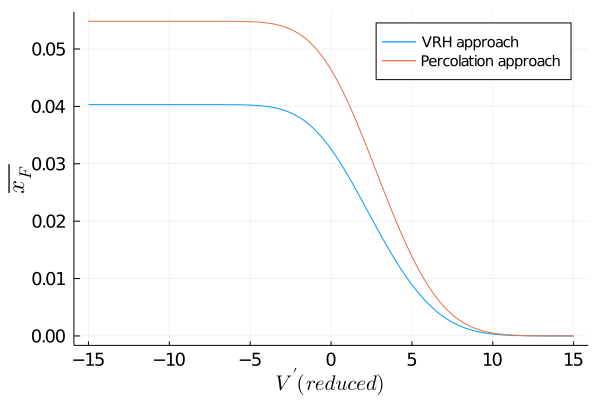

In [20]:
plot(range, xf_VRH, xlabel=L"V^\prime(reduced)", ylabel=L"\overline{x_F}", label="VRH approach", xguidefontsize=14,  yguidefontsize=16, legendfontsize=10, ytickfontsize=12,  xtickfontsize=12)
plot!(range, xf_Perco, label="Percolation approach")

In [5]:
mu_VRH = ((x, y) -> Conduction.electronMobility(semiconductor, x, y)).(Rnn_VRH, xf_VRH);
mu_Perco = ((x, y) -> Conduction.electronMobility(semiconductor, x, y)).(Rnn_Perco, xf_Perco);

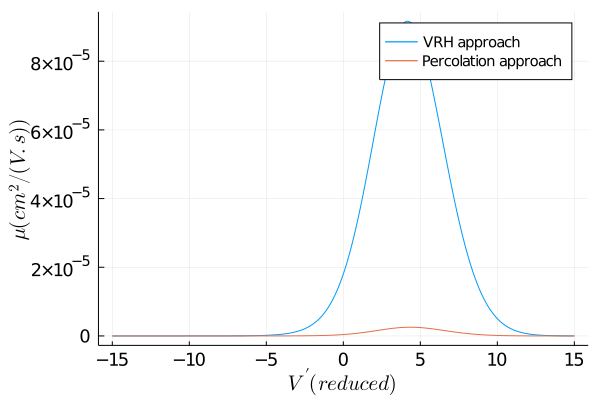

In [12]:
plot(range, mu_VRH, xlabel=L"V^\prime(reduced)", ylabel=L"\mu (cm^2/(V.s))", label="VRH approach", xguidefontsize=14,  yguidefontsize=14, legendfontsize=10, ytickfontsize=12,  xtickfontsize=12)
plot!(range, mu_Perco, label="Percolation approach")

In [13]:
sigma_VRH =  semiconductor.k * T * semiconductor.q * (x -> Conduction.DOS(semiconductor, x, T)).(range).*(x -> Conduction.F(semiconductor, x, T)).(range) .* mu_VRH;
sigma_Perco =  semiconductor.k * T * semiconductor.q * (x -> Conduction.DOS(semiconductor, x, T)).(range).*(x -> Conduction.F(semiconductor, x, T)).(range) .* mu_Perco;

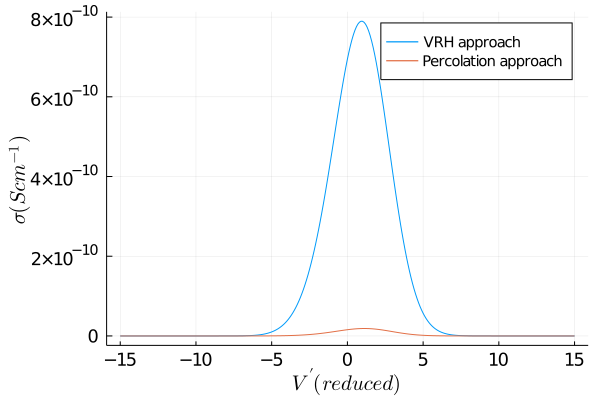

In [16]:
plot(range, sigma_VRH, xlabel=L"V^\prime (reduced)", ylabel=L"\sigma (S cm^{-1})", label="VRH approach", xguidefontsize=14,  yguidefontsize=14, legendfontsize=10, ytickfontsize=12,  xtickfontsize=12)
plot!(range, sigma_Perco, label="Percolation approach")

In [9]:
g(x, y) = Conduction.electronMobility(semiconductor, x, y);
f(x) = semiconductor.k * T * semiconductor.q * (x -> Conduction.DOS(semiconductor, x, T))(x) * (x -> Conduction.F(semiconductor, x, T))(x);
function h(x, Rnn)
    xf = Conduction.xf(semiconductor, Rnn, x, T);
    f(x) * g(Rnn, xf)
end;

h_VRH(x) = h(x, Conduction.RnnVRH(semiconductor, x, T));
h_Perco(x) = h(x, Conduction.RnnPercoField(semiconductor, x, T));

conductivity_VRH = Conduction.average_density_integral(h_VRH, 15);
conductivity_Perco = Conduction.average_density_integral(h_Perco, 15);

In [10]:
println(conductivity_VRH)
println(conductivity_Perco)

3.6818250983001922e-9
8.71316881796603e-11


In [11]:
t(x, y) = ((x, y) -> Conduction.t(semiconductor, x, y, T)).(x, y);
t_VRH = t(Rnn_VRH, range);
t_Perco = t(Rnn_Perco, range);

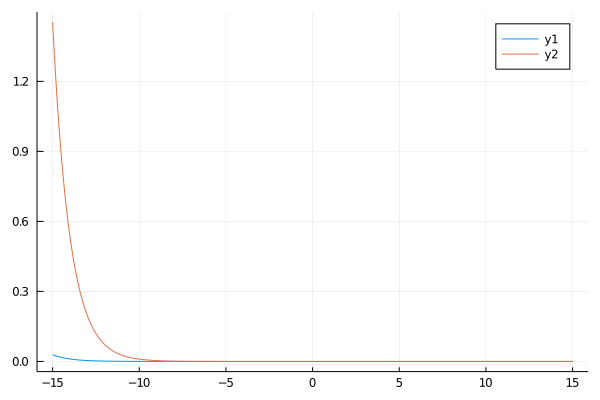

In [12]:
plot(range, t_VRH)
plot!(range, t_Perco)

In [13]:
function fn(x, Rnn)
    return Conduction.DOS(semiconductor, x, T) * Conduction.F(semiconductor, x, T) * Conduction.t(semiconductor, Rnn, x, T)
end;

function fd(x)
    return Conduction.DOS(semiconductor, x, T) * Conduction.F(semiconductor, x, T)
end;

fn_VRH(x) = fn(x, Conduction.RnnVRH(semiconductor, x, T));
fn_Perco(x) = fn(x, Conduction.RnnPercoField(semiconductor, x, T));

t_overall_VRH = Conduction.average_density(fn_VRH, fd, 15);

In [14]:
t_overall_Perco = Conduction.average_density(fn_Perco, fd, 15);

In [15]:
println(t_overall_VRH)
println(t_overall_Perco)

1.0096325154875229e-6
5.147263035468606e-5


In [16]:
ein_ratio(x, y, z) = ((x, y, z) -> Conduction.ein(semiconductor, x, y, z)).(x, y, z);
ein_VRH = ein_ratio(Rnn_VRH, xf_VRH, t_VRH);
ein_Perco = ein_ratio(Rnn_Perco, xf_Perco, t_VRH);

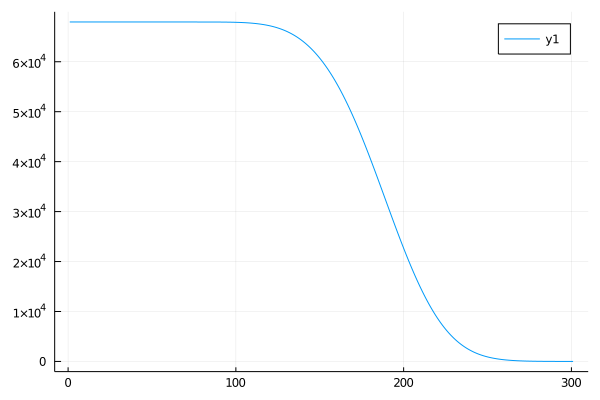

In [17]:
plot(ein_VRH * semiconductor.k * T / semiconductor.q)
plot(ein_Perco * semiconductor.k * T / semiconductor.q)

In [ ]:
function diffusion(x, Rnn)
    Rnn = Conduction.RnnVRH(semiconductor, x, T);
    xf = Conduction.xf(semiconductor, Rnn, x, T)
    t = Conduction.t(semiconductor, Rnn, x, T);
    return Conduction.D(semiconductor, Rnn, xf, t)
end

diffusion_VRH = (x -> diffusion(x, Conduction.RnnVRH(semiconductor, x, T))).(range);
diffusion_Perco = (x -> diffusion(x, Conduction.RnnPerco(semiconductor, x, T))).(range);

In [ ]:
plot(range, diffusion_VRH ./ mu_VRH * semiconductor.k * T / semiconductor.q)

In [ ]:
plot(range, diffusion_Perco ./ mu_Perco * semiconductor.k * T / semiconductor.q)

In [ ]:
function fd(x)
    return Conduction.DOS(semiconductor, x, T) * Conduction.F(semiconductor, x, T)
end;

function fn(x, Rnn)
    Rnn = Rnn
    xf = Conduction.xf(semiconductor, Rnn, x, T)
    t = Conduction.t(semiconductor, Rnn, x, T);
    return Conduction.DOS(semiconductor, x, T) * Conduction.F(semiconductor, x, T) * Conduction.D(semiconductor, Rnn, xf, t)
end

fn_VRH(x) = fn(x, Conduction.RnnVRH(semiconductor, x, T));
fn_Perco(x) = fn(x, Conduction.RnnPercoField(semiconductor, x, T))

diffusion_overall_VRH = Conduction.average_density(fn_VRH, fd, 15);
diffusion_overall_Perco = Conduction.average_density(fn_Perco, fd, 15);

In [ ]:
println(diffusion_overall_VRH)
println(diffusion_overall_Perco)

In [ ]:
function fd(x)
    return Conduction.DOS(semiconductor, x, T) * Conduction.F(semiconductor, x, T)
end;

function fn(x, Rnn)
    Rnn = Rnn;
    xf = Conduction.xf(semiconductor, Rnn, x, T);
    return Conduction.DOS(semiconductor, x, T) * Conduction.F(semiconductor, x, T) * Conduction.electronMobility(semiconductor, Rnn, xf)
end

fn_VRH(x) = fn(x, Conduction.RnnVRH(semiconductor, x, T));
fn_Perco(x) = fn(x, Conduction.RnnPercoField(semiconductor, x, T))

mobility_overall_VRH = Conduction.average_density(fn_VRH, fd, 15);
mobility_overall_Perco = Conduction.average_density(fn_Perco, fd, 15);

In [ ]:
println(mobility_overall_VRH)
println(mobility_overall_Perco)

In [ ]:
function fd(x)
    return Conduction.DOS(semiconductor, x, T) * Conduction.F(semiconductor, x, T)
end;

function fn(x, Rnn)
    Rnn = Rnn
    xf = Conduction.xf(semiconductor, Rnn, x, T)
    t = Conduction.t(semiconductor, Rnn, x, T);
    return Conduction.DOS(semiconductor, x, T) * Conduction.F(semiconductor, x, T) * Conduction.ein(semiconductor, Rnn, xf, t)
end

fn_VRH(x) = fn(x, Conduction.RnnVRH(semiconductor, x, T));
fn_Perco(x) = fn(x, Conduction.RnnPercoField(semiconductor, x, T))

ein_overall_VRH = Conduction.average_density(fn_VRH, fd, 15);
ein_overall_Perco = Conduction.average_density(fn_Perco, fd, 15);

In [ ]:
println(ein_overall_VRH * semiconductor.k * T / semiconductor.q)
println(ein_overall_Perco * semiconductor.k * T / semiconductor.q)